In [2]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt

# SHAPER
from pyshaper.CommonObservables import buildCommmonObservables
from pyshaper.Observables import Observable
from pyshaper.Shaper import Shaper

# Utils
from pyshaper.utils.data_utils import load_cmsopendata
from pyshaper.utils.plot_utils import plot_event


# Necessary GPU nonsense
import torch 

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 

Using CPU!


Max # of particles: 100
test


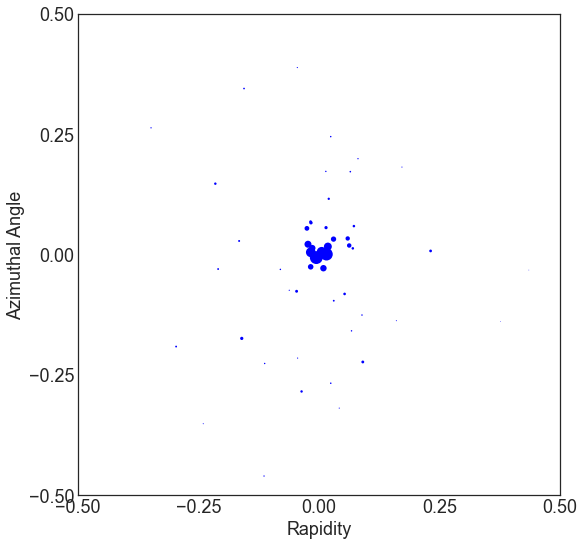

<AxesSubplot:xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [33]:
# Parameters
R = 0.5
beta = 1.0
N = 50
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"

# Load data (NOTE: Need the `energyflow` package installed for the default dataset, or provide your own data)
dataset, sim_weights, sim_factors = load_cmsopendata("~/.energyflow/", "sim", pt_lower, pt_upper, eta, quality, pad, n = N)


example_event = dataset[0]
plot_event(example_event[0], example_event[1], R, color = "blue")

# Spectral Representation

Given an event $\mathcal{E}$ with energy flow (density) $\mathcal(E)(x) = \sum_i E_i \delta(x-x_i)$, the spectral representation (density) $s(\omega)$ is $s(\omega) = \sum_{ij} E_i E_j \delta(\omega - \omega(x_i, x_j))$, where $\omega(x_i, x_j) \equiv \omega_{ij} = 1-\cos(\theta_{ij})$

In code, an event with $N$ particles will be represented in spectral representation by an $[1+{N \choose 2}] \times 2$ array, where the first column is a sorted list of pairwise distances $\omega_{ij}$ and the second is the associated pairwise energy $2E_i E_j$. The 0th element is $\omega_{ij} = 0$ with energy $\sum E_i^2$.  

TODO: numpy padding / jagged arrays

/var/folders/w0/0wlcf9nd71s7r2340_yg6njm0000gq/T/ipykernel_9667/1265039516.py:52: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 0.25)
/var/folders/w0/0wlcf9nd71s7r2340_yg6njm0000gq/T/ipykernel_9667/1265039516.py:66: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 0.25)


(2.455505561890606e-07, 0.25)

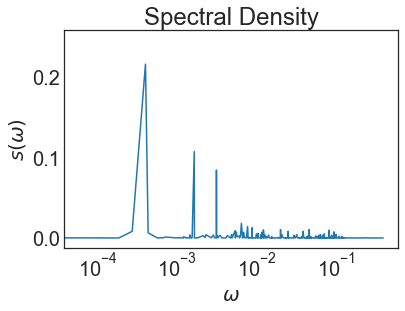

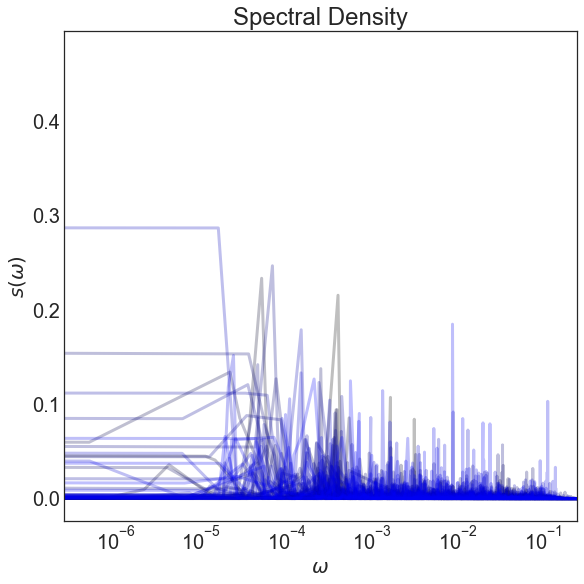

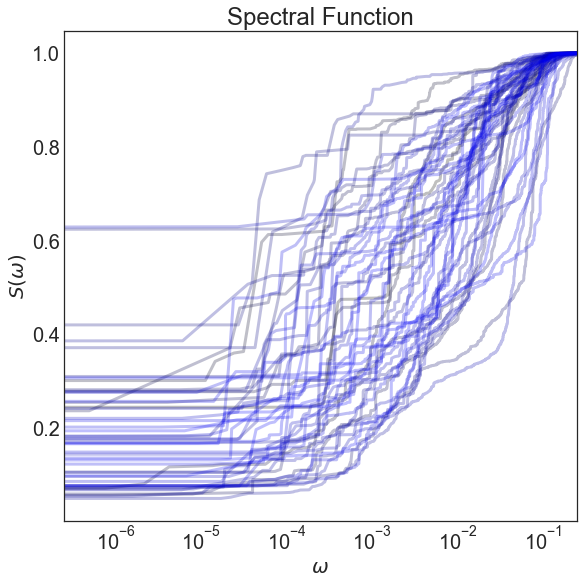

In [30]:
# TODO: my SHAPER representation of events is somewhat inefficient. do over.
def compute_spectral_representation(event, pad = 125, omega_max = 2):

    points, zs = event[0], event[1]
    euclidean_distance_squared = np.sum(np.square(points[:, None, :] - points[None, :, :]), axis=-1)
    
    # Upper Triangle Matrices
    omega_ij = np.triu(euclidean_distance_squared / 2)
    ee_ij = np.triu(zs[:,None] * zs[None,:])
    ee2 = np.trace(ee_ij)

    # Flatten to 1D Spectral Representation and remove 0s
    omega_n = omega_ij.flatten()
    ee_n = 2 * ee_ij.flatten()
    mask = omega_n > 0
    
    omega_n = omega_n[mask]
    ee_n = ee_n[mask]
    s = np.stack((omega_n, ee_n)).T
    
    # Sort and append 0
    s = s[s[:,0].argsort()]
    s0 = np.array(((0, ee2,),))
    s = np.concatenate((s0, s), axis = 0)

    return s

def cumulative_spectral_function(s):
    S = s.copy()
    S[:,1] = np.cumsum(S[:,1])
    return S


s = compute_spectral_representation(example_event)
plt.plot(s[:,0], s[:,1])
plt.xscale("log")
plt.title("Spectral Density")
plt.ylabel("$s(\omega)$")
plt.xlabel("$\omega$")


# Weird plot
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))
for (i,event) in enumerate(dataset):
    s = compute_spectral_representation(event)
    plt.plot(s[:,0], s[:,1], color = (0,0,np.sqrt(i/len(dataset))), alpha = 0.25, lw = 3)
plt.xscale("log")
plt.title("Spectral Density")
plt.ylabel("$s(\omega)$")
plt.xlabel("$\omega$")
plt.xlim(0, 0.25)


# Weird plot
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))
for (i,event) in enumerate(dataset):
    s = compute_spectral_representation(event)
    S = cumulative_spectral_function(s)
    plt.plot(S[:,0], S[:,1], color = (0,0,np.sqrt(i/len(dataset))), alpha = 0.25, lw = 3)
plt.xscale("log")
plt.title("Spectral Function")
plt.ylabel("$S(\omega)$")
plt.xlabel("$\omega$")
plt.xlim(0, 0.25)


    

# $p = 2$ Spectral Metric

In [40]:
def weighted_sum(s, p = 2, max_index = None, inclusive = True):

    if max_index is None:
        return np.sum(s[:,1] * np.power(s[:,0], 2))
    else:
        max_index = max_index + 1 if inclusive else max_index
        return np.sum(s[:max_index,1] * np.power(s[:max_index,0], 2))


def energy_sum(s, max_index = None, inclusive = True):
    if max_index is None:
        return np.sum(s[:,1])
    else:
        max_index = max_index + 1 if inclusive else max_index
        return np.sum(s[:max_index,1] )


def cross_term(s1, s2):

    # Cross term
    omega1s = s1[:,0]
    omega2s = s2[:,0]

    E1s = s1[:,1]
    E2s = s2[:,1]

    E1_cumsums = np.cumsum(E1s)
    E2_cumsums = np.cumsum(E2s)
    shifted_E1_cumsums = np.concatenate((np.array((E1_cumsums[0],)), E1_cumsums[:-1])) 
    shifted_E2_cumsums = np.concatenate((np.array((E2_cumsums[0],)), E2_cumsums[:-1])) 

    omega_n_omega_l = omega1s[:,None] * omega2s[None,:]
    minE = np.minimum(E1_cumsums[:,None], E2_cumsums[None,:])
    maxE = np.maximum(shifted_E1_cumsums[:,None], shifted_E2_cumsums[None,:])
    x = minE - maxE

    cross_term = np.sum(omega_n_omega_l * x * theta(x))
    return cross_term

def theta(x):

    return x > 0 


def ds2(s1, s2):

    term1 = weighted_sum(s1)
    term2 = weighted_sum(s2)

    return term1 + term2 - 2*cross_term(s1, s2)





In [41]:
# SANITY CHECKS

s = compute_spectral_representation(example_event)
print(ds2(s, s))



-3.729655473350135e-17


# 2-sPronginess

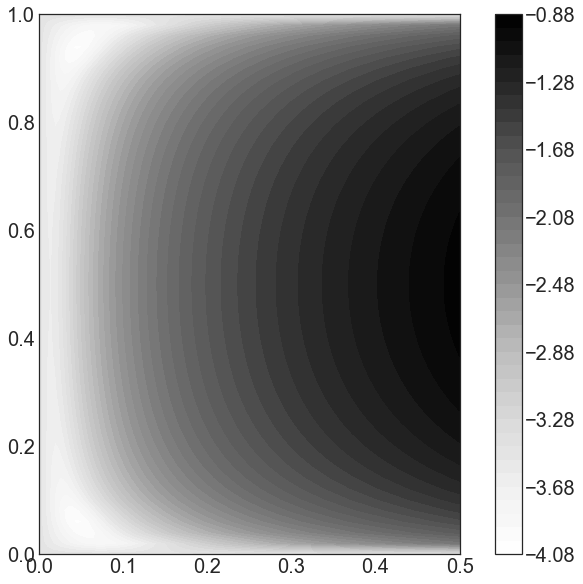

In [62]:
# 2-sPronginess

es = np.linspace(0,1, 100)
omegas = np.linspace(0,.5, 100)
Es, Omegas = np.meshgrid(es, omegas)
EMDs = np.zeros_like(Es)

for (i, e) in enumerate(es):
    for (j, omega) in enumerate(omegas):

            
        s2 = np.array((   (0, 1 - 2*(e*(1-e))), (omega, 2 * e * (1-e)),     ))
        d = ds2(s, s2)
        EMDs[j,i] = d


 # Weird plot
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))       
plt.contourf(Omegas, Es, np.log10(EMDs), levels = 50)
plt.colorbar()


# General Spectral Metric